# Lab 1: Word clouds

In this exercise, we'll generate some word clouds showing the words people use to describe especially good and bad wines.

Objectives:

- get logged into JupyterHub and create some notebooks
- load some data and manipulate it using pandas
- simple text normalization and tokenization
- collect word frequency statistics
- calculate measures of keyness (PMI and G2)
- generate word clouds


In [1]:
import re

import matplotlib.pyplot as plt
import nltk
import pandas as pd
from cytoolz import *
from wordcloud import WordCloud

## Data preparation

The data I'm using for this comes from Kaggle user zackthoutt and is (as of 23-Jan-2023) downloadable from here: https://www.kaggle.com/datasets/zynicide/wine-reviews. According to the docs, this dataset was scraped from *Wine Enthusiast* magazine in 2017.

As a first step, I'll read in the CSV file as downloaded from Kaggle using pandas:

In [2]:
df = pd.read_csv("/data/winemag-data_first150k.csv", index_col=0)
df

,country,description,designation,points,price,province,region_1,region_2,variety,winery
0,US,This tremendous 100% varietal wine hails from ...,Martha's Vineyard,96,235.0,California,Napa Valley,Napa,Cabernet Sauvignon,Heitz
1,Spain,"Ripe aromas of fig, blackberry and cassis are ...",Carodorum Selección Especial Reserva,96,110.0,Northern Spain,Toro,NaN,Tinta de Toro,Bodega Carmen Rodríguez
2,US,Mac Watson honors the memory of a wine once ma...,Special Selected Late Harvest,96,90.0,California,Knights Valley,Sonoma,Sauvignon Blanc,Macauley
3,US,"This spent 20 months in 30% new French oak, an...",Reserve,96,65.0,Oregon,Willamette Valley,Willamette Valley,Pinot Noir,Ponzi
4,France,"This is the top wine from La Bégude, named aft...",La Brûlade,95,66.0,Provence,Bandol,NaN,Provence red blend,Domaine de la Bégude
...,...,...,...,...,...,...,...,...,...,...
150925,Italy,Many people feel Fiano represents southern Ita...,NaN,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Feudi di San Gregorio
150926,France,"Offers an intriguing nose with ginger, lime an...",Cuvée Prestige,91,27.0,Champagne,Champagne,NaN,Champagne Blend,H.Germain
150927,Italy,This classic example comes from a cru vineyard...,Terre di Dora,91,20.0,Southern Italy,Fiano di Avellino,NaN,White Blend,Terredora
150928,France,"A perfect salmon shade, with scents of peaches...",Grand Brut Rosé,90,52.0,Champagne,Champagne,NaN,Champagne Blend,Gosset


We're in luck: the structure of the dataset looks pretty self-explanatory. We've got a text description of a wine, a numeric rating in points, and other meta-data like price, winery, variety, etc.

For this exercise I'm mostly just interested in the text and rating, so I'll look at these more closely. First, let's see the distribution of points values. They range from 80 to 100, with most in the mid to high 80s. 

<AxesSubplot: ylabel='Frequency'>

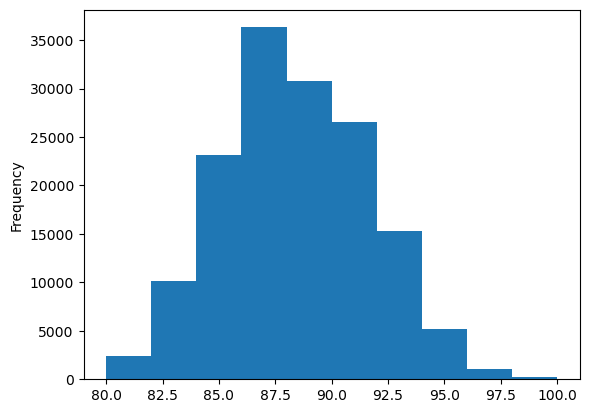

In [3]:
df["points"].plot(kind="hist")

No obvious problems or outliers there.

As a quick sanity check for the reviews, we can look at the distribution of text lengths. For convenience, I'll first add a `len` column to the dataframe with the length of the description (in characters) and then I'll plot the distribution. 

<AxesSubplot: ylabel='Frequency'>

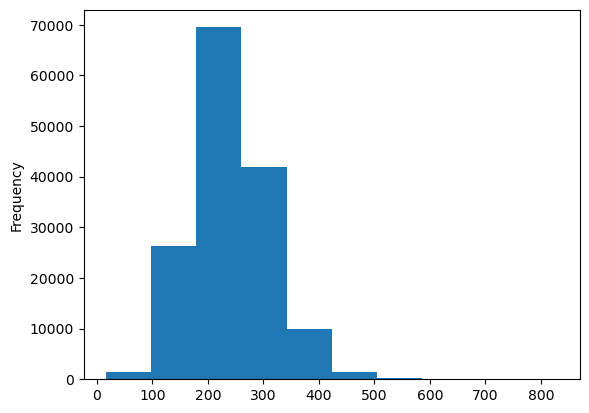

In [4]:
df["len"] = df["description"].apply(len)
df["len"].plot(kind="hist")

So far so good! No empty or gigantic reviews, and most are in a reasonable range. To be more thorough, I'll check the shortest and longest reviews for anything weird.

First the short reviews:

In [5]:
df.query("len < 25")

,country,description,designation,points,price,province,region_1,region_2,variety,winery,len
18827,US,Judi Sorensen Flom,Signature Collection,85,29.0,Oregon,Oregon,Oregon Other,Pinot Noir,King Estate,18
36008,US,"Thin, green and tannic.",NaN,82,28.0,Oregon,Rogue Valley,Southern Oregon,Cabernet Franc,Del Rio,23
81347,US,Judi Sorensen Flom,Signature Collection,85,29.0,Oregon,Oregon,Oregon Other,Pinot Noir,King Estate,18
103568,US,"Thin, green and tannic.",NaN,82,28.0,Oregon,Rogue Valley,Southern Oregon,Cabernet Franc,Del Rio,23
116396,US,Sweet and fruity.,NaN,82,11.0,Washington,Columbia Valley (WA),Columbia Valley,Merlot,Hoodsport,17
116483,US,"Very tannic, rough.",NaN,80,11.0,Washington,Columbia Valley (WA),Columbia Valley,Cabernet Sauvignon,Hoodsport,19
116488,US,"Very tannic, rough.",NaN,80,11.0,Washington,Columbia Valley (WA),Columbia Valley,Cabernet Merlot,Hoodsport,19
128156,US,Sweet and fruity.,NaN,82,11.0,Washington,Columbia Valley (WA),Columbia Valley,Merlot,Hoodsport,17
128453,US,"Very tannic, rough.",NaN,80,11.0,Washington,Columbia Valley (WA),Columbia Valley,Cabernet Sauvignon,Hoodsport,19
128458,US,"Very tannic, rough.",NaN,80,11.0,Washington,Columbia Valley (WA),Columbia Valley,Cabernet Merlot,Hoodsport,19


Some of the reviews are odd, e.g., "Judi Sorensen Flom" is probably the name of the reviewer and not the text of the review. "TAKE OUT...NOT IN US" is some kind of editorial comment. These might be scraping errors, or they might be errors in the original source.

More seriously, though, I see a bunch of duplicated reviews: 18827 and 81347 are identical, as are 36008 and 103568, and so on. This is probably not a problem specific to short reviews, but looking at short reviews makes it easier to spot. Fortunately, removing duplicates is easy in pandas.

In [6]:
df = df.drop_duplicates()

After removing the duplicates, the total number of reviews drops by around 30%, but we still have lots of text to work with.

In [7]:
len(df)

97851

Finally, we'll check the long reviews. With its default settings, pandas only shows us the first part of text columns, which won't help us much here. So first I'll set the max column width to something longer than the longest review:

In [8]:
pd.set_option("display.max_colwidth", 1000)

and then display the reviews:

In [9]:
df.query("len > 700")

,country,description,designation,points,price,province,region_1,region_2,variety,winery,len
22615,US,"Dark, dusty, strongly scented with barrel toast, coffee grounds and incense, this is the most substantial and complete version to date. Balancing cherry and plum fruit against the pretty barrel-infused tannins, it glides gracefully across the palate into a seamless finish. Saggi is the Long Shadows collaboration with Tuscany's Ambrogio and Giovanni Folonari. the blend in 2007 is 43% Sangiovese, 36% Cabernet Sauvignon and 21% Syrah. With each new vintage, the percentage of Sangiovese climbs, putting more Tuscany in this new world super-Tuscan wine. Dark, dusty, strongly scented with barrel toast, coffee grounds and incense, this is the most substantial and complete version to date. Balancing cherry and plum fruit against the pretty barrel-infused tannins, it glides gracefully across the palate into a seamless finish.",NaN,91,45.0,Washington,Columbia Valley (WA),Columbia Valley,Red Blend,Saggi,829
42904,US,"This very fine Cabernet wants a little time in the cellar. Right now, it's tight in tannins, with some acidic bitterness in the finish. The flavors are of black currants and smoky new oak. The Morisoli Vineyard has been home to very good, ageable bottlings from the likes of Sequoia Grove and Elyse, but in the last few years, Meander has expressed its terroir best. Try after 2012.This very fine Cabernet wants a little time in the cellar. Right now, it's tight in tannins, with some acidic bitterness in the finish. The flavors are of black currants and smoky new oak. The Morisoli Vineyard has been home to very good, ageable bottlings from the likes of Sequoia Grove and Elyse, but in the last few years, Meander has expressed its terroir best. Try after 2012.",Morisoli Vineyard,93,100.0,California,Rutherford,Napa,Cabernet Sauvignon,Meander,764


All good! Whoever scraped this text did a decent job (except for the duplicates).

## Tokenization

Next up, we need to tokenize the text. For this exercise, all we care about are the words, and only the frequent words at that. That means we can ignore upper/lower case distinctions, punctuation, numbers, etc.

To tokenize a text, we first fold it to lower case

In [10]:
df["description"].loc[0].lower()

'this tremendous 100% varietal wine hails from oakville and was aged over three years in oak. juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. enjoy 2022–2030.'

Then remove non-letters by replacing them with spaces:

In [11]:
re.sub(r"[^a-z]+", " ", df["description"].loc[0].lower())

'this tremendous varietal wine hails from oakville and was aged over three years in oak juicy red cherry fruit and a compelling hint of caramel greet the palate framed by elegant fine tannins and a subtle minty tone in the background balanced and rewarding from start to finish it has years ahead of it to develop further nuance enjoy '

And then split what's left up at spaces:

In [12]:
re.sub(r"[^a-z]+", " ", df["description"].loc[0].lower()).split()

['this',
 'tremendous',
 'varietal',
 'wine',
 'hails',
 'from',
 'oakville',
 'and',
 'was',
 'aged',
 'over',
 'three',
 'years',
 'in',
 'oak',
 'juicy',
 'red',
 'cherry',
 'fruit',
 'and',
 'a',
 'compelling',
 'hint',
 'of',
 'caramel',
 'greet',
 'the',
 'palate',
 'framed',
 'by',
 'elegant',
 'fine',
 'tannins',
 'and',
 'a',
 'subtle',
 'minty',
 'tone',
 'in',
 'the',
 'background',
 'balanced',
 'and',
 'rewarding',
 'from',
 'start',
 'to',
 'finish',
 'it',
 'has',
 'years',
 'ahead',
 'of',
 'it',
 'to',
 'develop',
 'further',
 'nuance',
 'enjoy']

We want to do this to every review, so package it up into a function that can apply to a pandas column:

In [13]:
def tokenize(text):
    return re.sub(r"[^a-z]+", " ", text.lower()).split()

In [14]:
df["description"].apply(tokenize)

0                                     [this, tremendous, varietal, wine, hails, from, oakville, and, was, aged, over, three, years, in, oak, juicy, red, cherry, fruit, and, a, compelling, hint, of, caramel, greet, the, palate, framed, by, elegant, fine, tannins, and, a, subtle, minty, tone, in, the, background, balanced, and, rewarding, from, start, to, finish, it, has, years, ahead, of, it, to, develop, further, nuance, enjoy]
1                                                                           [ripe, aromas, of, fig, blackberry, and, cassis, are, softened, and, sweetened, by, a, slathering, of, oaky, chocolate, and, vanilla, this, is, full, layered, intense, and, cushioned, on, the, palate, with, rich, flavors, of, chocolaty, black, fruits, and, baking, spices, a, toasty, everlasting, finish, is, heady, but, ideally, balanced, drink, through]
2                                                                                                                [mac, watson, honors, t

## Frequencies

Next step is to count word frequencies in good and bad wine reviews, as well as overall totals. 

What do we mean by good and bad wines? That's kind of arbitrary, but of the 91,000 wine reviews, about 4,000 of them are for wines with fewer that 83 points and about an equal number have more than 93 points. So, let's call those **bad** and **good** reviews.

In [15]:
len(df), len(df.query("points < 83")), len(df.query("points > 93"))

(97851, 4004, 4244)

Now, to collect word frequencies. We can use either the [`Counter` class](https://docs.python.org/3/library/collections.html?highlight=counter#counter-objects)) that is part of the python standard library or the [`FreqDist` class](https://www.nltk.org/api/nltk.probability.FreqDist.html#nltk.probability.FreqDist) that is part of NLTK and adds some useful linguistic-y features to `Counter`. 

Either one will take a sequence of strings and count up how many times each unique string occurs in the sequence. Our `tokenize` function defined above will convert a single review from a string into a sequence of strings. Feeding that into `FreqDist` gives us word frequencies for that review.

In [16]:
nltk.FreqDist(tokenize(df["description"].loc[0]))

FreqDist({'and': 4, 'from': 2, 'years': 2, 'in': 2, 'a': 2, 'of': 2, 'the': 2, 'to': 2, 'it': 2, 'this': 1, ...})

If we try to count the words in all the reviews, though, we get a problem:

In [17]:
nltk.FreqDist(df["description"].apply(tokenize))

TypeError: unhashable type: 'list'

This fails because we haven't given it a sequence of tokens. We've given it a sequence of sequences of tokens! What we need here is the function `concat`, which flattens out sequences of sequences for us

In [18]:
list(concat([[1, 2, 3], [4, 5, 6], [7, 8, 9]]))

[1, 2, 3, 4, 5, 6, 7, 8, 9]

Putting it all together, we get word counts for all the reviews, just the good reviews, and just the bad reviews.

In [19]:
total = nltk.FreqDist(concat(df["description"].apply(tokenize)))
bad = nltk.FreqDist(concat(df.query("points < 83")["description"].apply(tokenize)))
good = nltk.FreqDist(concat(df.query("points > 93")["description"].apply(tokenize)))

## Keywords

The most *frequent* words in good and bad reviews are mostly just common English words, like *and* and *the*

In [20]:
good.most_common(5)

[('and', 13194), ('the', 10330), ('of', 6967), ('a', 6893), ('is', 4698)]

In [21]:
bad.most_common(5)

[('and', 8078), ('the', 4802), ('a', 3742), ('with', 3147), ('of', 2680)]

For our word clouds, we went want are the most *interesting* words. In corpus linguistics, interestingly frequent words are known as **keywords** and there are a number of **keyness** metrics that we can use to rank words by "interestingness". We'll try two. 

The first is, **pointwise mutual information**, derived from Shannon's information theory and  introduced into corpus linguistics by [Church and Hanks (1990)](https://aclanthology.org/J90-1003). The second, due to [Dunning (1993)](https://aclanthology.org/J93-1003/), is based on the **likelihood ratio test**.

Fortunately for us, both are implemented as part of NTLK's [association metrics module](https://www.nltk.org/api/nltk.metrics.association.html#module-nltk.metrics.association)

In [22]:
metrics = nltk.BigramAssocMeasures()
metrics.likelihood_ratio(bad["vegetal"], (total["vegetal"], bad.N()), total.N())

898.1608122734913

We just need to call the appropriate metric for all the words in the bad (or good) subset of the reviews. PMI tends to exagerate the interestingness of very low frequency words, so to be safe we'll skip anything that doesn't occur at least ten times.

In [25]:
bad_llr = nltk.FreqDist()
bad_pmi = nltk.FreqDist()

for w in bad:
    if bad[w] > 10:
        bad_llr[w] = metrics.likelihood_ratio(bad[w], (total[w], bad.N()), total.N())
        bad_pmi[w] = metrics.pmi(bad[w], (total[w], bad.N()), total.N())

In [26]:
bad_llr.most_common(10)

[('tastes', 917.6368095797732),
 ('vegetal', 898.1608122734913),
 ('harsh', 872.6510163321619),
 ('simple', 696.2977424907458),
 ('thin', 658.5911821734105),
 ('sour', 637.9383251182721),
 ('smells', 615.5171984069423),
 ('sweet', 603.5035261330756),
 ('rich', 562.4142730901659),
 ('sugary', 560.0501539115318)]

In [27]:
bad_pmi.most_common(10)

[('gluey', 4.480050958996177),
 ('disagreeable', 4.451138267080939),
 ('acceptable', 4.409954832008317),
 ('weird', 4.397588798804204),
 ('bizarre', 4.268546853802466),
 ('harsh', 4.150357947059774),
 ('vinegary', 4.078885634298892),
 ('acrid', 4.065013459717335),
 ('devoid', 4.021025447339998),
 ('boring', 4.0174850896347465)]

## Word clouds

Finally, at last, we are ready to make some word clouds!

We can use a very nice [word cloud generator](https://github.com/amueller/word_cloud) already implemented in python. All we need to do is pass it the keyness scores we just calculated (the `WordCloud` API calls them "frequencies" but it doesn't really care what the numbers represent).

In [28]:
def cloud(freqs, title, k=50):
    plt.figure(figsize=(8, 8))
    wc = WordCloud(
        width=750, height=750, background_color="black"
    ).generate_from_frequencies(freqs)
    plt.title(title)
    plt.axis("off")
    plt.imshow(wc, interpolation="bilinear")
    plt.show()

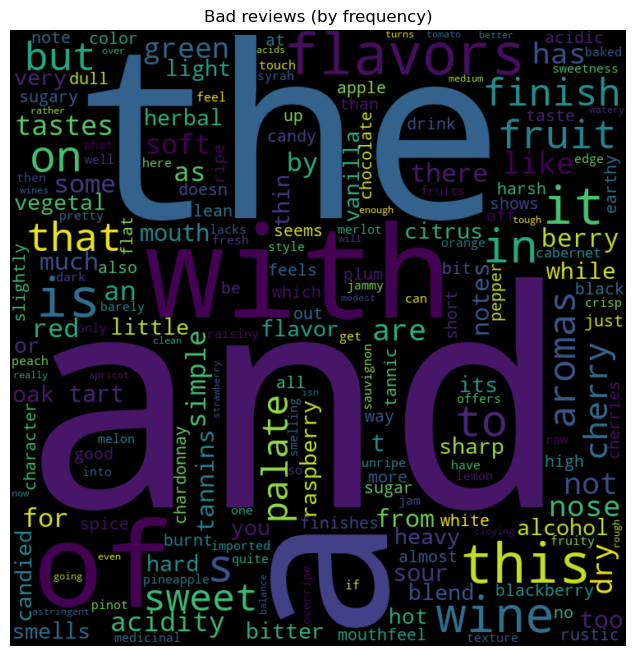

In [29]:
cloud(bad, "Bad reviews (by frequency)")

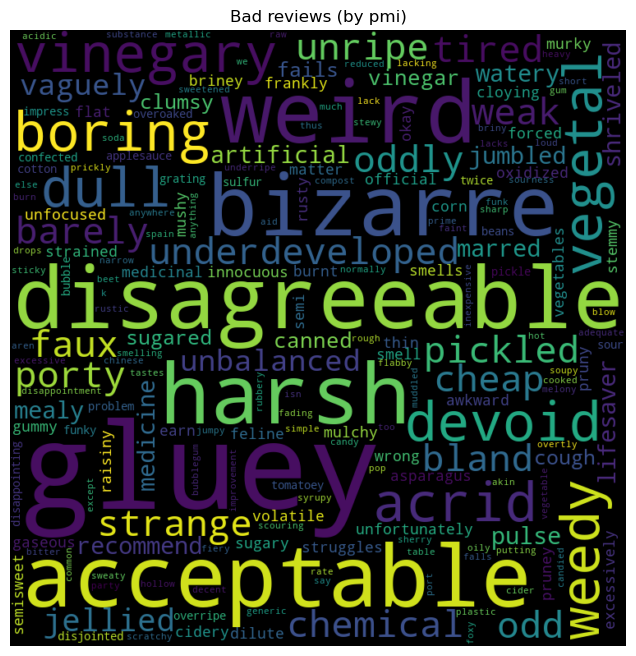

In [30]:
cloud(bad_pmi, "Bad reviews (by pmi)")

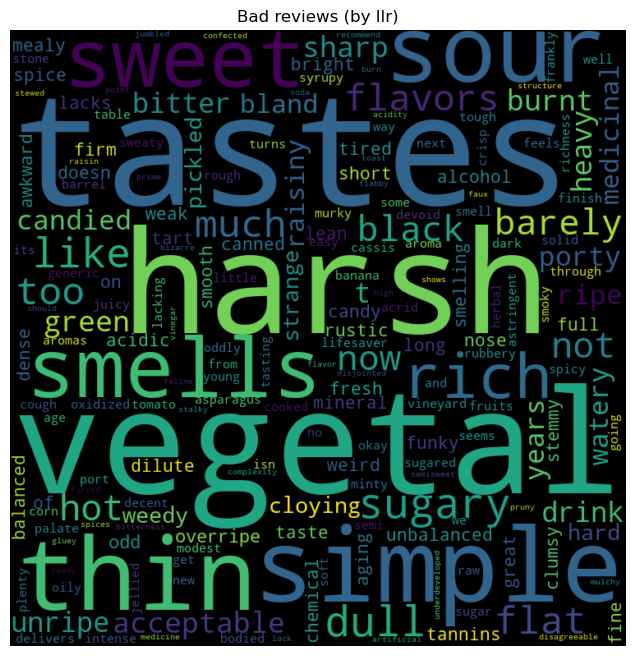

In [31]:
cloud(bad_llr, "Bad reviews (by llr)")

Most of these make sense, but what does *meoru* mean? Let's see the reviews that use that word:

In [32]:
df.query('description.str.contains("meoru")')

,country,description,designation,points,price,province,region_1,region_2,variety,winery,len


None? Hmm, that can't be right. Maybe it was capitalizaed?

In [33]:
df.query('description.str.contains("Meoru")')

,country,description,designation,points,price,province,region_1,region_2,variety,winery,len
18018,South Korea,"This is an approachable version of the slightly wild and dry red Meoru grape of South Korea. Spicy and bright on the nose, the wine follows with vibrant fruit flavors that are a touch pointed when not paired with food. A great way to explore a lesser-known wine-producing region.",Wild Grape Dry,82,16.0,Jiri Valley,NaN,NaN,Meoru,Keum Hwa Winery,279
18022,South Korea,"Meoru is an indigenous red grape grown on Mt. Jiri in South Korea. The aromas are spicy and smoky, and on the palate, the wine is spicy and bright, if a little dry and wild. Meoru is reputed to have extraordinary antioxidant strength, so beyond possibly doing something good for your body, you'll also find this wine an exotic discovery.",Castle Wild Grape Dry,81,11.0,Jiri Valley,NaN,NaN,Meoru,Keum Hwa Winery,337


Aha, there it is. Not sure what that would be associated with bad wines, but....

To get word clouds for good reviews, we can just repeat the steps above. (Note that cutting and pasting code like this is generally not a good idea, since it's easy to make mistakes. It's usually better to define a function (as we did for `tokenize` and `cloud`) when you want to reuse code.)

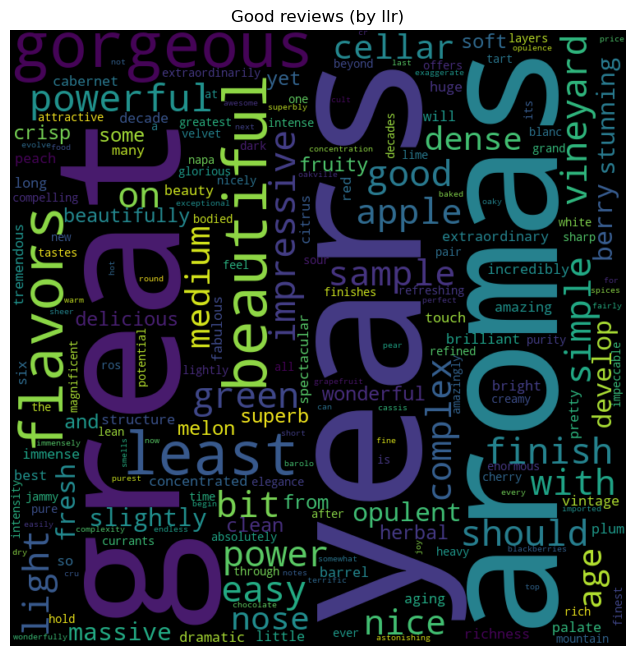

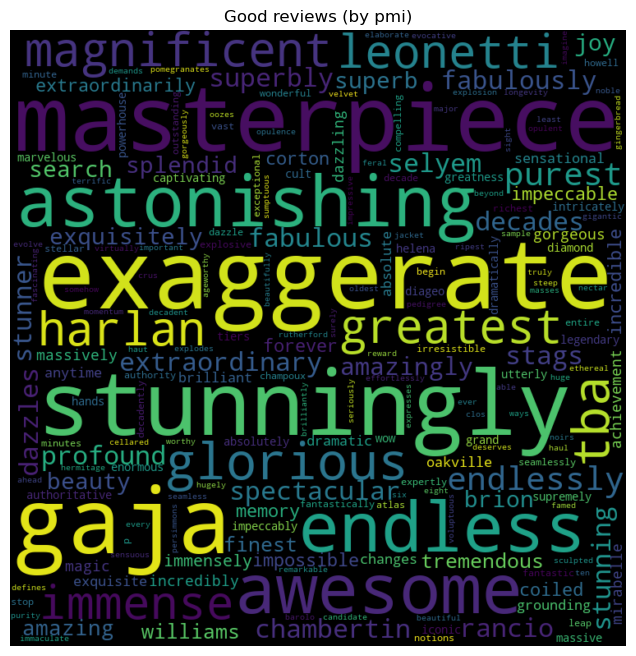

In [34]:
good = nltk.FreqDist(concat(df.query("points > 93")["description"].apply(tokenize)))

good_llr = nltk.FreqDist()
good_pmi = nltk.FreqDist()

for w in good:
    if good[w] > 10:
        good_llr[w] = metrics.likelihood_ratio(good[w], (total[w], good.N()), total.N())
        good_pmi[w] = metrics.pmi(good[w], (total[w], good.N()), total.N())

cloud(good_llr, "Good reviews (by llr)")
cloud(good_pmi, "Good reviews (by pmi)")